### Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG

## Classificação de expressões faciais com Redes Neurais Convolucionais (CNN)

Neste trabalho vamos construir um classificador de expressões faciais utilizando Redes Neurais Convolucionais (CNN). O projeto é dividido em três etapas principais:

1. **Captura de imagens**: Utilizando a webcam, o aluno captura imagens de seu rosto em três expressões (feliz, triste e furioso)
2. **Treinamento da CNN**: Uma rede neural convolucional é treinada para reconhecer as três expressões
3. **Predição ao vivo**: O modelo treinado é utilizado para classificar as expressões do rosto em tempo real através da webcam

As imagens são capturadas em escala de cinza com resolução configurável de nxn pixels. O modelo utiliza camadas convolucionais para extrair características das imagens e camadas densas para classificação.

**Classes do modelo:**
- FELIZ (0)
- TRISTE (1)
- FURIOSO (2)
- NEUTRO (quando confiança < 60%)

## 1. Preparação do ambiente

In [2]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#cria as pastas para armazenar o dataset e os modelos treinados
import os
os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)

### 1.1 Importação de pacotes

In [4]:
#para exportar o requeriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para captura de imagens
import os
import cv2
import time
import glob
import shutil

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
2025-12-19 12:48:40.277142: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_

pygame 2.6.1 (SDL 2.32.54, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-12-19 12:48:40.308027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-19 12:48:40.308052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-19 12:48:40.308590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-19 12:48:40.312947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1.2 Verificando versões

In [5]:
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

print(f"Pandas version: {pd.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")

print(f"Seaborn version: {sns.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
NumPy version: 1.26.4
TensorFlow version: 2.15.0
Pandas version: 2.3.3
Matplotlib version: 3.10.6
Seaborn version: 0.13.2
OpenCV version: 4.9.0


### 1.3 Checagem de GPU

In [6]:
#verificacao de GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: True
Dispositivos GPU TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-12-19 12:48:48.468780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-19 12:48:48.508240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-19 12:48:48.508432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 2. Configurações do experimento

In [7]:
#------------------------------
#CONFIGURACOES DE CAPTURA
#------------------------------

#tempo de captura em segundos
capture_time = 10

#quantidade de fotos por classe
capture_count = 50

#resolucao das imagens (quadradas)
img_size = 128

#tamanho da area de captura na tela (em pixels)
box_size = 400

#realizar nova captura (True) ou usar capturas existentes (False)
#se True, apaga o conteudo da pasta 'captura' e tira novas fotos
#se False, usa as fotos existentes na pasta 'captura'
new_capture = True

#------------------------------
#CONFIGURACOES DE TREINAMENTO
#------------------------------

#gerar um novo modelo ou usar um pronto
new_model = True

#realizar data augmentation (rotacao, zoom, flip)
augmentation_exec = True

#realizar escalonamento de dados (escala 0-1)
normalization_exec = True

#threshold de confianca para classificar como NEUTRO
confidence_threshold = 0.60

#nome do modelo
model_name = 'cnn_expressoes_faciais'

#classes do modelo
class_names = ['FELIZ', 'TRISTE', 'FURIOSO']
num_classes = len(class_names)

## 3. Captura de imagens

### 3.1 Funções auxiliares de captura

In [8]:
def prepare_capture_folder(base_path='dataset'):
    """prepara a pasta de captura"""
    folder_path = os.path.join(base_path, 'captura')

    #se a pasta existe, apaga e recria
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f'pasta {folder_path} apagada')
    
    os.makedirs(folder_path)
    print(f'pasta {folder_path} criada')
    return folder_path

def capture_images(class_name, num_images, capture_seconds, img_size, box_size, save_path):
    """captura imagens da webcam com countdown e preview"""
    
    #usa o backend AVFoundation no macOS para evitar crash
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('erro: nao foi possivel abrir a webcam')
        return False

    #calcula intervalo entre capturas
    interval = capture_seconds / num_images

    print(f'\n=== capturando {class_name.upper()} ===')
    print(f'posicione-se em {class_name.upper()} e pressione SPACE para iniciar...')
    print('pressione Q para cancelar')
    
    window_name = 'Captura'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)

    try:
        #aguarda usuario pressionar space para iniciar
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem para facilitar posicionamento
            frame = cv2.flip(frame, 1)

            #adiciona texto de instrucao
            cv2.putText(frame, f'Posicione-se em {class_name.upper()}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, 'Pressione SPACE para iniciar', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 255, 0), 2)

            cv2.imshow(window_name, frame)

            key = cv2.waitKey(1) & 0xFF
            if key == ord(' '):
                break
            elif key == ord('q'):
                cap.release()
                cv2.destroyWindow(window_name)
                cv2.waitKey(1)
                return False

        #inicia captura com countdown
        start_time = time.time()
        images_captured = 0
        last_capture_time = 0

        while images_captured < num_images:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem
            frame = cv2.flip(frame, 1)

            elapsed = time.time() - start_time
            remaining = max(0, capture_seconds - elapsed)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 0, 255), 2)

            #adiciona countdown e contador de fotos
            cv2.putText(frame, f'Tempo: {remaining:.1f}s', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Fotos: {images_captured}/{num_images}', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'{class_name.upper()}', (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow(window_name, frame)

            #captura imagem no intervalo correto
            if elapsed - last_capture_time >= interval:
                #extrai regiao de interesse (ROI)
                roi = frame[cy - box_size//2:cy + box_size//2,
                            cx - box_size//2:cx + box_size//2]

                #converte para escala de cinza
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                #redimensiona para tamanho desejado
                roi_resized = cv2.resize(roi_gray, (img_size, img_size))

                #salva imagem
                filename = os.path.join(save_path, f'{class_name}_{images_captured + 1:03d}.jpg')
                cv2.imwrite(filename, roi_resized)

                images_captured += 1
                last_capture_time = elapsed

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            if elapsed >= capture_seconds and images_captured >= num_images:
                break

    finally:
        #libera a camera e fecha a janela de forma segura
        cap.release()
        cv2.destroyWindow(window_name)
        #processa eventos pendentes
        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)

    print(f'{images_captured} imagens de {class_name.upper()} capturadas')
    return True

### 3.2 Execução da captura

In [ ]:
#executa captura se new_capture=True
if new_capture:
    capture_path = prepare_capture_folder()
    
    print('\n' + '='*50)
    print('INICIANDO CAPTURA DE IMAGENS')
    print('='*50)
    print(f'tempo por classe: {capture_time} segundos')
    print(f'fotos por classe: {capture_count}')
    print(f'area de captura: {box_size}x{box_size} pixels')
    print(f'resolucao final: {img_size}x{img_size} pixels (escala de cinza)')
    print('='*50)
    
    #captura cada classe
    for class_name in ['feliz', 'triste', 'furioso']:
        success = capture_images(class_name, capture_count, capture_time, img_size, box_size, capture_path)
        if not success:
            print(f'captura de {class_name} cancelada')
            break
        time.sleep(1)  #pequena pausa entre capturas
    
    print('\n' + '='*50)
    print('CAPTURA FINALIZADA')
    print('='*50)
else:
    capture_path = os.path.join('dataset', 'captura')
    if os.path.exists(capture_path):
        print(f'usando dataset existente: {capture_path}')
    else:
        print(f'erro: pasta {capture_path} nao encontrada')
        print('defina new_capture=True para criar uma nova captura')

## 4. Análise de dados

### 4.1 Carregamento das imagens

In [10]:
def load_images(folder_path, class_names, img_size):
    """carrega imagens e retorna arrays de dados e rotulos"""
    images = []
    labels = []
    
    for idx, class_name in enumerate(class_names):
        pattern = os.path.join(folder_path, f'{class_name.lower()}_*.jpg')
        files = glob.glob(pattern)
        
        print(f'{class_name}: {len(files)} imagens encontradas')
        
        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels)

#carrega as imagens
capture_path = os.path.join('dataset', 'captura')
x_data, y_data = load_images(capture_path, class_names, img_size)

print(f'\ntotal de imagens: {len(x_data)}')
print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos: {y_data.shape}')

FELIZ: 50 imagens encontradas
TRISTE: 50 imagens encontradas
FURIOSO: 50 imagens encontradas

total de imagens: 150
shape dos dados: (150, 128, 128)
shape dos rotulos: (150,)


### 4.2 Visualização das amostras

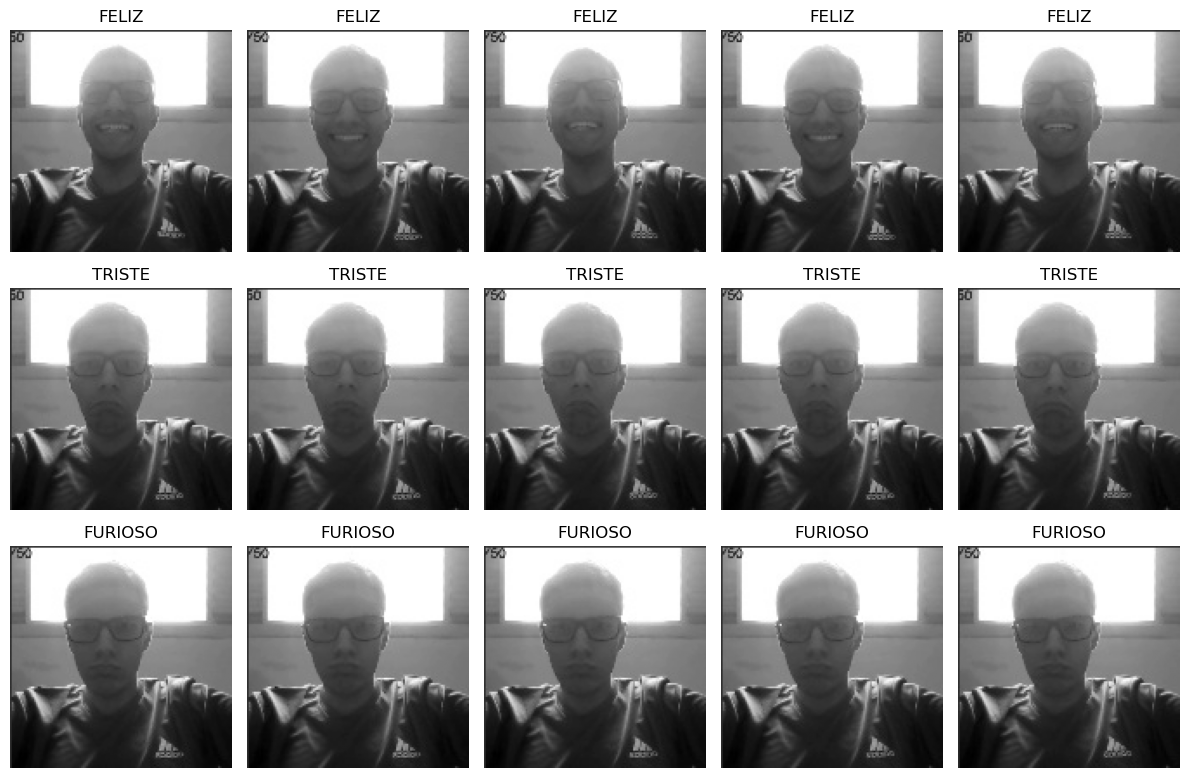

In [11]:
#visualiza algumas amostras de cada classe
fig, axs = plt.subplots(3, 5, figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_indices = np.where(y_data == i)[0]
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)
    
    for j, idx in enumerate(sample_indices):
        axs[i, j].imshow(x_data[idx], cmap='gray')
        axs[i, j].set_title(f'{class_name}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### 4.3 Sumarização estatística

In [12]:
def sumarizacao(x_data, y_data, class_names):
    stats = []

    for idx, class_name in enumerate(class_names):
        class_data = x_data[y_data == idx]
        
        count = len(class_data)
        mean_pixel = round(np.mean(class_data), 2)
        std_pixel = round(np.std(class_data), 2)
        min_pixel = round(np.min(class_data), 2)
        max_pixel = round(np.max(class_data), 2)
        
        stats.append([class_name, count, mean_pixel, std_pixel, min_pixel, max_pixel])

    headers = ['Classe', 'Quantidade', 'Média Pixel', 'Desvio Padrão', 'Mínimo', 'Máximo']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

sumarizacao(x_data, y_data, class_names)

| Classe   |   Quantidade |   Média Pixel |   Desvio Padrão |   Mínimo |   Máximo |
|:---------|-------------:|--------------:|----------------:|---------:|---------:|
| FELIZ    |           50 |        143.23 |           67.18 |       39 |      255 |
| TRISTE   |           50 |        140.54 |           67.48 |       37 |      255 |
| FURIOSO  |           50 |        138.73 |           67.85 |       35 |      255 |


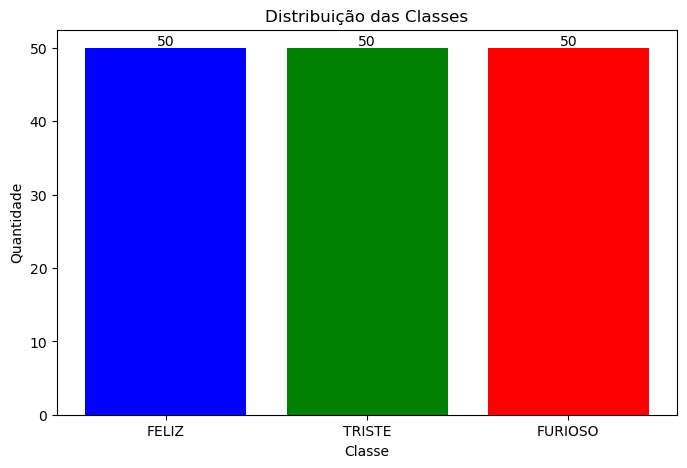

In [13]:
#distribuicao das classes
unique, counts = np.unique(y_data, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([class_names[i] for i in unique], counts, color=['blue', 'green', 'red'])
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição das Classes')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.4 Pré-processamento dos dados

In [14]:
#adiciona dimensao do canal (escala de cinza = 1 canal)
x_data = x_data.reshape(x_data.shape[0], img_size, img_size, 1)

#normalizacao (escala 0-1)
if normalization_exec:
    x_data = x_data.astype('float32') / 255.0
    print('dados normalizados para escala [0, 1]')

#converte rotulos para one-hot encoding
y_data_cat = to_categorical(y_data, num_classes)

print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos (one-hot): {y_data_cat.shape}')
#150 dados para 3 saídas

dados normalizados para escala [0, 1]
shape dos dados: (150, 128, 128, 1)
shape dos rotulos (one-hot): (150, 3)


## 5. Separação dos conjuntos de dados (treino, validação e teste)

In [15]:
#separa treino+validacao e teste
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data_cat, test_size=0.2, shuffle=True, random_state=42, stratify=y_data_cat
)

#separa treino e validacao
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42, stratify=y_train_val
)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (90, 128, 128, 1)
y_train shape: (90, 3)
x_val shape: (30, 128, 128, 1)
y_val shape: (30, 3)
x_test shape: (30, 128, 128, 1)
y_test shape: (30, 3)


### 5.1 Data Augmentation (opcional)

data augmentation configurado


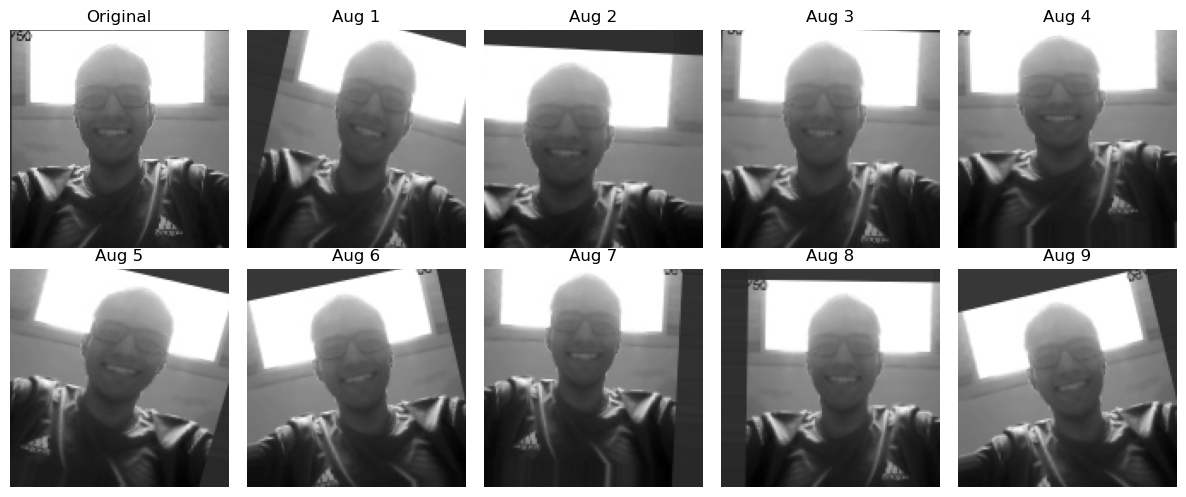

In [16]:
#configura data augmentation - aplica rotações, zoom, 
if augmentation_exec:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    print('data augmentation configurado')
    
    #visualiza exemplos de augmentation
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    sample_img = x_train[0:1]
    
    axs[0, 0].imshow(sample_img[0].reshape(img_size, img_size), cmap='gray')
    axs[0, 0].set_title('Original')
    axs[0, 0].axis('off')
    
    for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
        if i >= 9:
            break
        row = (i + 1) // 5
        col = (i + 1) % 5
        axs[row, col].imshow(batch[0].reshape(img_size, img_size), cmap='gray')
        axs[row, col].set_title(f'Aug {i+1}')
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    datagen = None
    print('data augmentation desativado')

## 6. Treinamento do modelo

### 6.1 Construção do modelo

In [17]:
#empilhamento de camadas para construir uma CNN

act_function = 'relu'
act_function_out = 'softmax' #soma as saidas da relu e divide pelo valor relu/softmax
#transforma em escala percentual
#softmax - pega a saida de qualquer neuronio e transforma em porcentagem - ate dar 100% em um neuronio
drop = 0.25
initializer = tensorflow.keras.initializers.HeNormal()

#entrada
inputs = Input(shape=(img_size, img_size, 1), dtype='float32', name='input')
#1 - uma imagem entra por vez - o ultimo 1 no shape

#bloco convolucional 1
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(inputs)
#32 kernels (tamanho do kernel), stride 1 e padding 1
conv1 = BatchNormalization()(conv1) #ajusta os valores se ficarem muito ruins da camada de conv1
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
drop1 = Dropout(drop)(pool1) #25% das vezes nao vai haver uma atualizacao do kernel - por causa do dropout de 0.25

#bloco convolucional 2
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = Dropout(drop)(pool2)

#bloco convolucional 3
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
drop3 = Dropout(drop)(pool3)

#camadas densas
flat = Flatten()(drop3) #achata as linhas da matriz para um vetor
dense1 = Dense(256, activation=act_function, kernel_initializer=initializer)(flat)
dense1 = BatchNormalization()(dense1)
drop4 = Dropout(0.5)(dense1)

#saida
outputs = Dense(num_classes, activation=act_function_out, name='output')(drop4)

#geracao do modelo
cnn_model = Model(inputs, outputs, name=model_name)

2025-12-19 12:52:09.895787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-19 12:52:09.896113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-19 12:52:09.896253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 6.2 Inspecionando o modelo

In [18]:
cnn_model.summary()

Model: "cnn_expressoes_faciais"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 

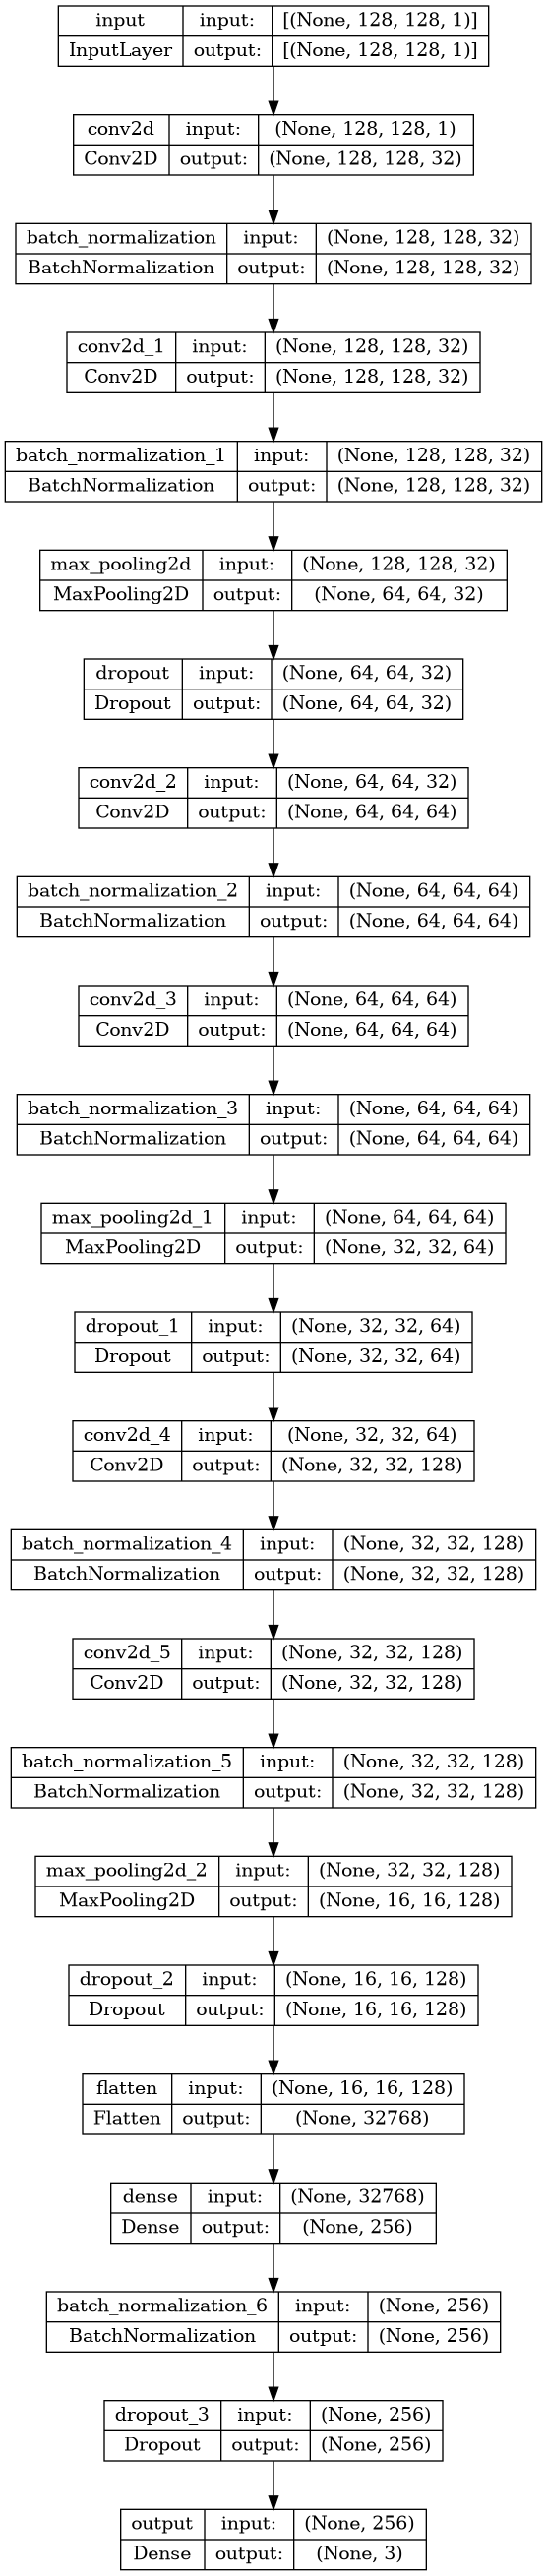

In [19]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True, rankdir="TB")

In [20]:
print('x_train type:', type(x_train))
print('y_train type:', type(y_train))
print('x_train dtype:', x_train.dtype)
print('y_train dtype:', y_train.dtype)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
x_train dtype: float32
y_train dtype: float32
x_train shape: (90, 128, 128, 1)
y_train shape: (90, 3)


### 6.3 Otimização do modelo

In [21]:
if new_model:
    
    opt = Adam(learning_rate=0.001)
    
    cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    cp = ModelCheckpoint(
        filepath='models/best_model.weights.h5',
        save_weights_only=True,
        monitor='val_loss', #vai salvar os melhores pesos baseados na validacao
        mode='min', #salvando o que da o minimo erro
        save_best_only=True
    )
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=80, restore_best_weights=True)
    
    if augmentation_exec and datagen is not None:
        #treina com data augmentation
        history = cnn_model.fit(
            datagen.flow(x_train, y_train, batch_size=8),
            #batch_size - quantidade de erros acumulados para depois aplicar o backpropagation
            #nesse caso - acumula 8 vezes e faz a media 
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp],
            steps_per_epoch=len(x_train) // 8
        )
    else:
        #treina sem data augmentation
        history = cnn_model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp],
            batch_size=8,
            shuffle=True
        )
    
    np.save('models/history_model.npy', history.history)
    cnn_model.load_weights('models/best_model.weights.h5')
    cnn_model.save('models/' + model_name + '.h5')
    
else:
    cnn_model = load_model('models/' + model_name + '.h5')

Epoch 1/300


2025-12-19 12:52:45.413981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_expressoes_faciais/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-12-19 12:52:45.668563: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-12-19 12:52:47.505609: I external/local_xla/xla/service/service.cc:168] XLA service 0x777569a65700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-19 12:52:47.505629: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-19 12:52:47.518838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766159567.598261    9325 device_compiler.h:186] Compiled clus

11/11 [==============================] - 10s 325ms/step - loss: 2.4677 - accuracy: 0.3293 - val_loss: 3.0120 - val_accuracy: 0.3333
Epoch 2/300
11/11 [==============================] - 1s 60ms/step - loss: 1.9239 - accuracy: 0.4268 - val_loss: 2.0460 - val_accuracy: 0.3333
Epoch 3/300
11/11 [==============================] - 0s 35ms/step - loss: 1.7000 - accuracy: 0.4024 - val_loss: 4.3772 - val_accuracy: 0.3333
Epoch 4/300
11/11 [==============================] - 0s 35ms/step - loss: 1.4131 - accuracy: 0.4878 - val_loss: 5.0589 - val_accuracy: 0.3333
Epoch 5/300
11/11 [==============================] - 0s 35ms/step - loss: 1.3298 - accuracy: 0.5000 - val_loss: 5.8472 - val_accuracy: 0.3333
Epoch 6/300
11/11 [==============================] - 0s 35ms/step - loss: 1.0332 - accuracy: 0.5366 - val_loss: 6.5957 - val_accuracy: 0.3333
Epoch 7/300
11/11 [==============================] - 0s 35ms/step - loss: 1.2882 - accuracy: 0.4268 - val_loss: 5.9752 - val_accuracy: 0.3333
Epoch 8/300
11/1

/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = 'support_files/uepa.mp3'

if os.path.exists(arquivo_mp3):
    pygame.mixer.music.load(arquivo_mp3)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        continue

print('Sucesso!')

Sucesso!


### 6.4 Avaliação do modelo com curva de convergência

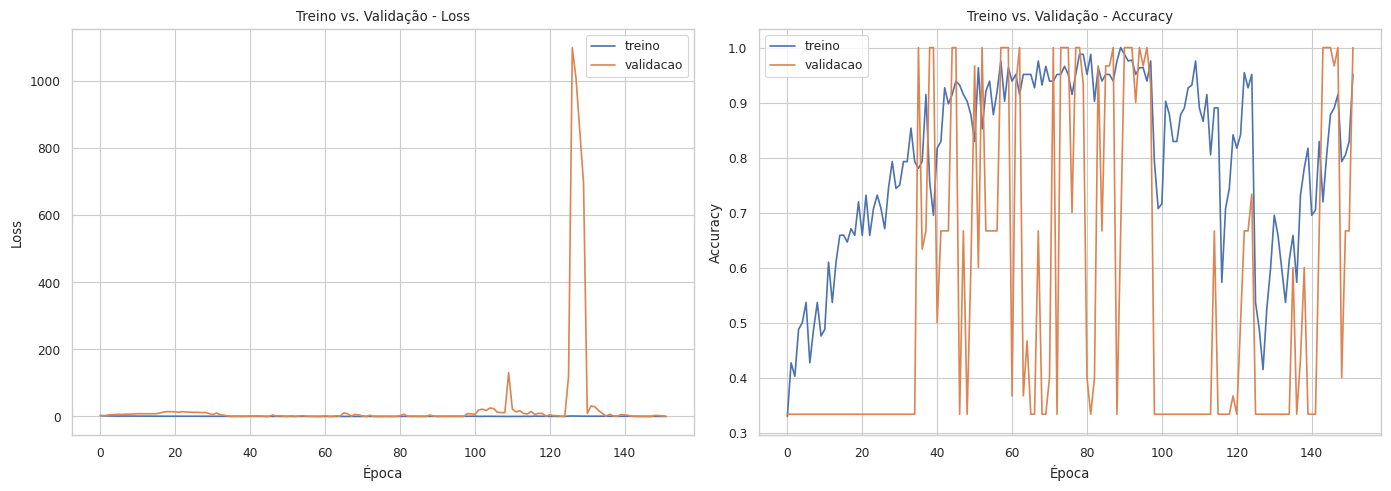

In [24]:
history = np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#grafico de loss
ax1.plot(history['loss'], label='treino')
ax1.plot(history['val_loss'], label='validacao')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Época')
ax1.set_title('Treino vs. Validação - Loss')
ax1.legend()

#grafico de accuracy
ax2.plot(history['accuracy'], label='treino')
ax2.plot(history['val_accuracy'], label='validacao')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.set_title('Treino vs. Validação - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [25]:
#realiza predicoes no conjunto de teste
y_pred_prob = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f'predicoes realizadas: {len(y_pred)}')

1/1 [==============================] - 0s 125ms/step
predicoes realizadas: 30


### 7.2 Calculando a taxa de acerto com base na matriz de confusão

In [26]:
#calculando a matriz de confusao
cm = confusion_matrix(y_true, y_pred)

#calculando a taxa de acerto
accuracy = np.trace(cm) / cm.sum()
accuracy_percent = round(accuracy * 100, 2)
print(f"Taxa de Acerto: {accuracy_percent:.2f}%")

Taxa de Acerto: 100.00%


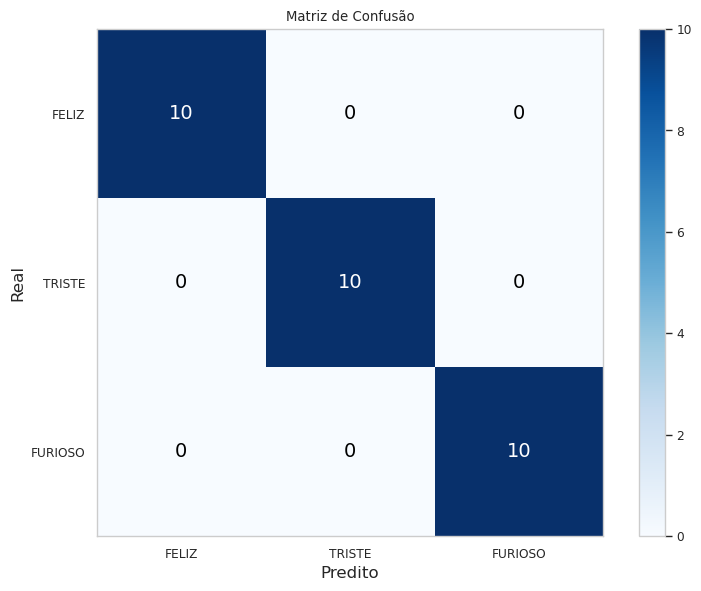

In [27]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.imshow(cm, cmap='Blues')

plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão')

#adiciona rotulos dos eixos
plt.xticks(range(num_classes), class_names)
plt.yticks(range(num_classes), class_names)

threshold = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > threshold else 'black'
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color=color, fontsize=14)

plt.colorbar()
plt.tight_layout()
plt.show()

### 7.3 Visualização das predições

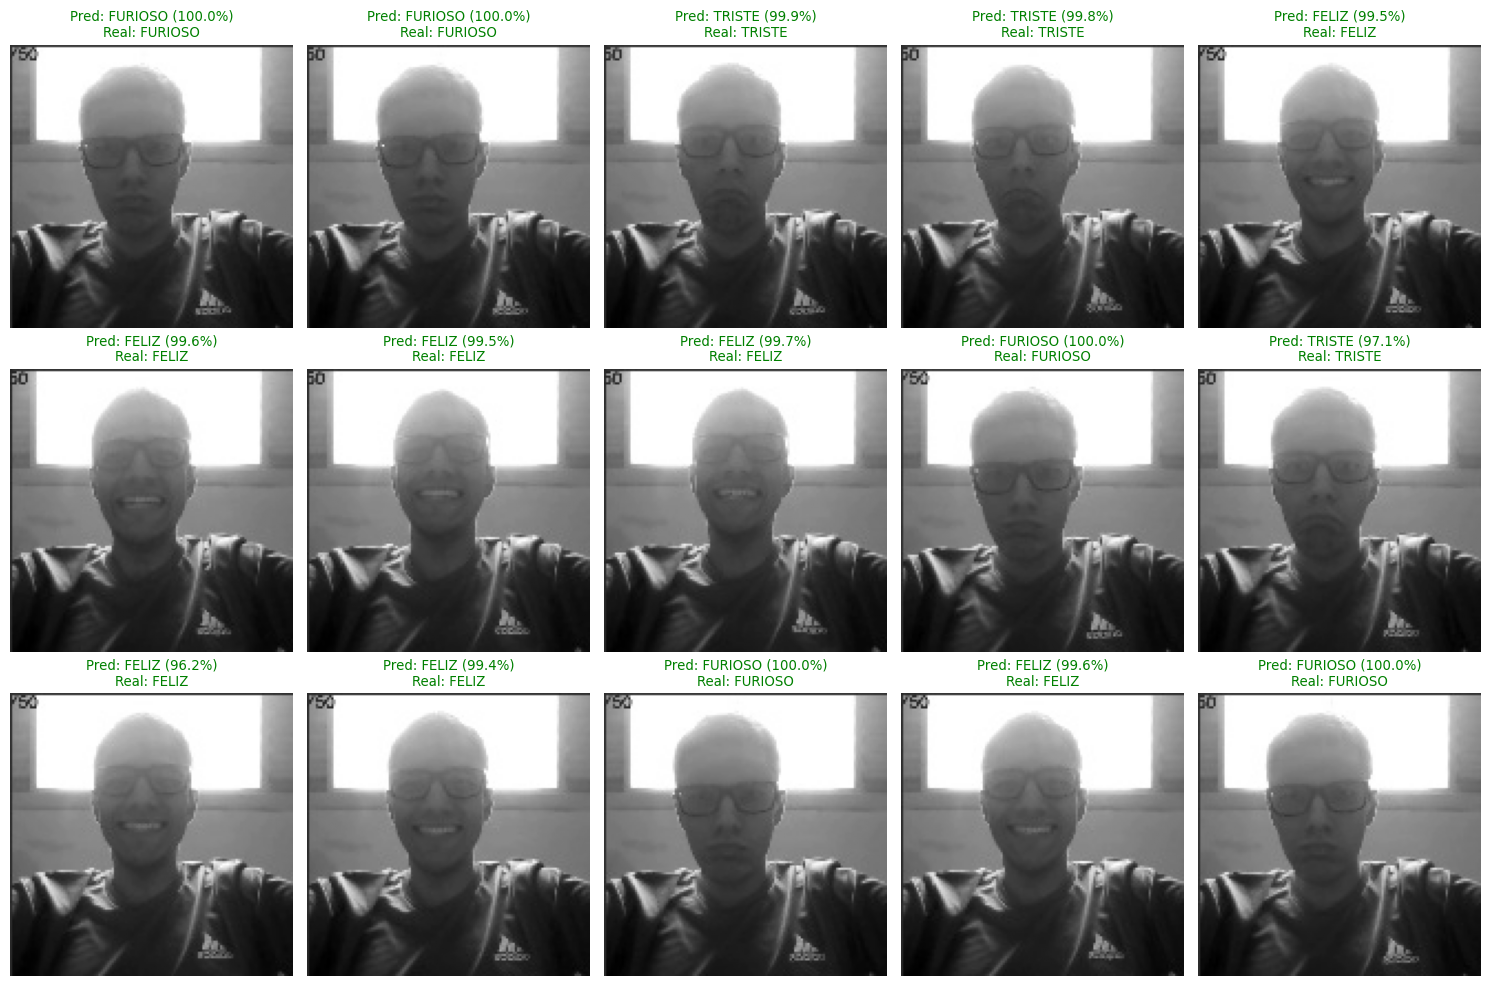

In [28]:
#visualiza algumas predicoes
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

indices = np.random.choice(len(x_test), 15, replace=False)

for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap='gray')
    
    pred_class = class_names[y_pred[idx]]
    true_class = class_names[y_true[idx]]
    confidence = y_pred_prob[idx][y_pred[idx]] * 100
    
    color = 'green' if y_pred[idx] == y_true[idx] else 'red'
    axs[row, col].set_title(f'Pred: {pred_class} ({confidence:.1f}%)\nReal: {true_class}', color=color)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## 8. Predição ao vivo

### 8.1 Função de predição ao vivo

In [29]:
def live_prediction(model, class_names, img_size, box_size, confidence_threshold):
    """realiza predicao ao vivo usando a webcam"""
    
    #usa o backend AVFoundation no macOS para evitar crash
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print('erro: nao foi possivel abrir a webcam')
        return
    
    print('=== PREDICAO AO VIVO ===')
    print('posicione-se dentro do quadrado')
    print('pressione Q ou feche a janela para sair')
    print('='*25)
    
    window_name = 'Predicao ao Vivo'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            #espelha a imagem
            frame = cv2.flip(frame, 1)
            
            #define area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            
            #extrai ROI
            roi = frame[cy - box_size//2:cy + box_size//2, 
                        cx - box_size//2:cx + box_size//2]
            
            #preprocessa para o modelo
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_resized = cv2.resize(roi_gray, (img_size, img_size))
            roi_normalized = roi_resized.astype('float32') / 255.0
            roi_input = roi_normalized.reshape(1, img_size, img_size, 1)
            
            #realiza predicao
            prediction = model.predict(roi_input, verbose=0)
            pred_class = np.argmax(prediction)
            confidence = prediction[0][pred_class]
            
            #determina o texto a exibir
            if confidence >= confidence_threshold:
                label = f'{class_names[pred_class]} ({confidence*100:.1f}%)'
                color = (0, 255, 0)  #verde
            else:
                label = f'NADA ({confidence*100:.1f}%)'
                color = (0, 0, 255)  #vermelho
            
            #desenha area de captura
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2), 
                        (cx + box_size//2, cy + box_size//2), color, 2)
            
            #adiciona texto com o resultado
            cv2.putText(frame, label, (cx - box_size//2, cy - box_size//2 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            #mostra barra de confianca
            bar_width = int(box_size * confidence)
            cv2.rectangle(frame, (cx - box_size//2, cy + box_size//2 + 10),
                        (cx - box_size//2 + bar_width, cy + box_size//2 + 30), color, -1)
            cv2.rectangle(frame, (cx - box_size//2, cy + box_size//2 + 10),
                        (cx + box_size//2, cy + box_size//2 + 30), color, 2)
            
            #adiciona instrucoes
            cv2.putText(frame, 'Pressione Q para sair', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow(window_name, frame)
            
            #verifica se usuario quer sair
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            
            #verifica se janela foi fechada
            try:
                if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
                    break
            except:
                break
    
    finally:
        #libera a camera e fecha a janela de forma segura
        cap.release()
        cv2.destroyWindow(window_name)
        #processa eventos pendentes
        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)
    
    print('predicao ao vivo finalizada')

### 8.2 Executar predição ao vivo

In [30]:
#carrega o modelo se necessario
if 'cnn_model' not in dir() or cnn_model is None:
    cnn_model = load_model('models/' + model_name + '.h5')
    print('modelo carregado')

#inicia predicao ao vivo
live_prediction(cnn_model, class_names, img_size, box_size, confidence_threshold)

=== PREDICAO AO VIVO ===
posicione-se dentro do quadrado
pressione Q ou feche a janela para sair


QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is not the object's thread (0x4645ab70).
Cannot move to target thread (0x46118b40)

QObject::moveToThread: Current thread (0x46118b40) is n

predicao ao vivo finalizada
